# NLIW depression flux calculations
### Testing to develop better functions for paper submission

In [1]:
import os
import glob
import numpy as np
import xarray as xr
import cmocean.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from d2spike.utils import nan_gauss_xr

import seaborn as sns
from wootils.plotnice import saveagu, vert_stack, plot_align, basic_ts, plot_axislabels

import sys
sys.path.insert(0, '../')
# from chp3_plotfuncs import *
from chp3_fluxfuncs import get_nliw_times, calc_flux, get_nliw_fronts, calc_settling, sample_fluxterms, reynolds_decomp
from chp3_basefuncs import load_c, load_ntu, rotate_event, rotate_data
from chp3_paperplots import plot_papersetup, plot_paperflux, plot_paperprofiles_v2, plot_appsummary
from chp3_samplefuncs import sample_loop_ssc

sns.set()
sns.set_style("white")
sns.set_style("ticks")
# Set the tick length
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['ytick.minor.size'] = 0

# sudo mount -t drvfs '\\drive.irds.uwa.edu.au\OGS-ODFDA-001' /mnt/share

pyODAS not found, not importing pIMOS.xrwrap.rsi_vmp


In [2]:
field_trip = 'RS2019'
wave_type = 'NLIW'
temp_file = 'RowleyShoals_Gridded_Mooring_T_SBE56.nc'
land_temp = 'RowleyShoals_L150_SBE56Data.nc'
moor = 'T150'

In [3]:
# Set key data directories and outputs
project_root = r'/mnt/c/Users/00099894/Large_Data/Experiments'
work_dir = r'/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/PhD'
load_dir = os.path.join(project_root, field_trip, wave_type)

fig_dir = f'{wave_type}_figures'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

## Load the data for event 5

In [4]:
# Load temp data
temp_nc = os.path.join(project_root, field_trip, temp_file)
ds_temp = xr.open_dataset(temp_nc, group=moor)
ds_temp.close()

# Load lander temp data
land_nc = os.path.join(project_root, field_trip, land_temp)
ds_land = xr.open_dataset(land_nc, group='L150_SBE56_T__881')
ds_land.close()

sig_file = 'SIG_meandataENU.nc'
sug_full = os.path.join('../0_identify_despike_save', sig_file)
ds_sig = xr.open_dataset(sug_full)
# echo_dp = xr.DataArray(data=ds_sig['echo'].values[:,np.newaxis], dims=['time', 'height'],\
#                        coords={'time': ds_sig['echo'].time, 'height': [5.0]})
# sig_mean_ssc = load_c(echo_dp, ds_temp, os.path.join(work_dir, 'pl'), field_trip)

ds_l_ntu = load_ntu(work_dir, '0360_burstmedian', mooring='L150')
ds_l_ntu = ds_l_ntu.rename({'Datenum':'time'})
ssc_good = (ds_l_ntu*2.62 - 4.38)/2.33

ds_h_ntu = load_ntu(work_dir, '0359_burstmedian', mooring='L150')
ssc_uppp = (ds_h_ntu*2.52 - 3.95)/2.33

In [5]:
wav_tx = get_nliw_times()
wav_fronts = get_nliw_fronts()

# c_wave = 0.6
cb_labels = ['$\\overline{C_t}$', '$-\overline{W}\overline{C}_z$', '$-\overline{w\'c\'}_z$',\
                '$-\overline{U}\overline{C}_x$']

ylim = (2.4,7.42)
# pltgf_z, pltgf_t = 4, 30
n_samp = 100
flx_bar = 0.149
gf_h, gf_t = 4, 300
thin_v, thin_t = 2, 10
sett = 0.000
ulinemin = 0.69
wtick = 0.025

In [9]:
def plotall_grl(ds, u_r_mean, c_turb, t_list, temp_ix, tx_sig, ulinemin, wtick,\
                ssc_uppp, ssc_good, wav_fronts, ylim):

    # Plot the GRL figure
    h_rat = [1,5,3,1,3,3,3,3,2]
    fig, ax = vert_stack(9, hsize=16.6/1.4, vsize=2.4/1.4, hspace=0.05, h_ratio=h_rat)
    par = ax[0].twinx()
    axf = np.append(ax, par).flatten()

    # Plot mean U and W at single height
    u_r_mean.plot(ax=ax[0], c='k', linewidth=1.5)
    ds['w_mean'].sel(height=5.02).isel(time=tx_sig).plot(ax=par, c='r', linewidth=1.5)
    ax[0].set_ylabel('$\overline{U}$\n[m s$^{-1}$]')
    ax[0].set_ylim(-ulinemin, ulinemin)
    par.set_ylabel('$\overline{W}$\n[m s$^{-1}$]')
    par.yaxis.label.set_color('red')
    par.tick_params(axis='y', colors='red')
    ax[0].grid() 
    par.set_title('')
    par.set_ylim(-wtick*(ulinemin/0.5), wtick*(ulinemin/0.5))

    # Plot temperature
    ds_temp['Temperature'].isel(time=temp_ix).plot.contourf(ax=ax[1], cmap=plt.cm.viridis, levels=np.arange(18,32,1),\
                        cbar_kwargs={'pad':0.01, 'label':'Temperature\n[$^\circ$C]'})
    ds_temp['Temperature'].isel(time=temp_ix).plot.contour(ax=ax[1], colors='k', linewidths=0.1,\
                        levels=np.arange(18,31,1), add_colorbar=False)
    ax[1].set_ylim(None,119)

    # Plot C
    ax[2].fill_between(c_turb.time, 0.5, 1.5, color='grey', alpha=1)
    c_turb.plot(ax=ax[2], cmap=cm.turbid, vmin=0, vmax=34,\
                cbar_kwargs={'pad': 0.01, 'label': 'C\n[g m$^{-3}$]'})
    ax[2].fill_between(c_turb.time, 0.5, 0.9, color='grey', alpha=1)

    # Line plots
    sig_mean_ssc = nan_gauss_xr(c_turb.sel(height=3.0, method='nearest'), 75*4)[::30]
    sig_mean_ssc.plot(ax=ax[3], c='grey', linewidth=1.5)
    ssc_uppp.plot(ax=ax[3], c='k', linestyle=':', linewidth=1.5)
    ssc_good.plot(ax=ax[3], c='k', linewidth=1.5)
    ax[3].set_ylim(0, 120)
    ax[3].set_xlabel('')
    ax[3].set_ylabel('C\n[g m$^{-3}$]')
    ax[3].grid() 

    # Plot the fluxes
    for x, f_term, cbl in zip(ax[4:-1], t_list, cb_labels):
        f_term.median(dim='sample').plot(cmap='PuOr', vmin=-0.079, vmax=0.079,\
                        ax=x, center=0,\
                        cbar_kwargs={'pad':0.01 , 'label':cbl})
        x.set_ylabel('m ASB')
        x.set_ylim(ylim[0], ylim[1])

    ## Plot height integral - dC/dt
    dc_dt_int = t_list[0].sel(height=slice(ylim[0], ylim[1])).integrate('height')

    ax[-1].plot(t_list[0].time.values, dc_dt_int.median(dim='sample'), c='orange', zorder=10)
    ax[-1].fill_between(t_list[0].time.values, dc_dt_int.quantile(0.5-0.475, dim='sample'),\
                        dc_dt_int.quantile(0.5+0.475, dim='sample'), color='orange', alpha=0.5, zorder=9)

    # Plot height integral - sum of other terms
    dc_oth_int = (t_list[1] + t_list[2] + t_list[3])\
                            .sel(height=slice(ylim[0], ylim[1])).integrate('height')
        
    ax[-1].plot(t_list[0].time.values, dc_oth_int.median(dim='sample'), c='purple', zorder=8)
    ax[-1].fill_between(t_list[0].time.values, dc_oth_int.quantile(0.5-0.475, dim='sample', skipna=False),\
                        dc_oth_int.quantile(0.5+0.475, dim='sample', skipna=False), color='purple', alpha=0.5, zorder=7)

    ax[-1].grid()
    ax[-1].set_ylim(-0.33, 0.33)
    ax[-1].set_ylabel('$\int_z$\n[g m$^{-2}$ s$^{-1}$]')
    # ax[-1].set_ylabel('')

    plot_align(ax)
    basic_ts(t_list[0].time.values, ax)

    myFmt = mdates.DateFormatter('%H:%M')
    ax[-1].xaxis.set_major_formatter(myFmt)
    plot_axislabels(ax, pos='topleft', h_ratios=h_rat)

    x_msb = [1,2,4,5,6,7]
    for xiax, x in enumerate(ax):
        if xiax in x_msb:
            x.set_ylabel('m ASB')

    x_vll = [2,4,5,6,7]
    for xiax, x in enumerate(ax):
        if xiax in x_vll:
            if xiax == 2:
                ccc =  'w'
            else:
                ccc = 'k'
            x.vlines(wav_fronts[1], ymin=0.5, ymax=c_turb.height.values[-1], color=ccc, ls='--', lw=1)
    for wf, wl in zip(wav_fronts[1], ['$t_0$', '$t_1$', '$t_2$']):
        ax[2].text(wf, 6.8, wl, color='w', fontsize=14, ha='left', zorder=10, weight='bold')
        ax[7].text(wf, 6.8, wl, color='k', fontsize=14, ha='left', zorder=10, weight='bold')
    return fig, ax

In [7]:
# Load wave data
for ii, (wt, wf) in enumerate(zip(wav_tx, wav_fronts)):
    if (ii == 1):
    
        # Load fluxes
        sig_fil = f'{wave_type}_E{int(ii+1)}_fluxattrs.nc'
        vel_file = os.path.join(load_dir, sig_fil)
        ds = xr.open_dataset(vel_file)
        xr.Dataset.close(ds)
        print(f'Loaded {sig_fil}')


        sig_fil = f'{wave_type}_{int(ii+1)}_ENU.nc'
        vel_file = os.path.join(load_dir, sig_fil)
        ds_turb = xr.open_dataset(vel_file)
        xr.Dataset.close(ds_turb)

        sig_fil = f'{wave_type}_{int(ii+1)}_echo.nc'
        vel_file = os.path.join(load_dir, sig_fil)
        ds_echo = xr.open_dataset(vel_file)
        xr.Dataset.close(ds_echo)        

        start = np.timedelta64(5, 'm')
        end = (2*(ds.time.values[-1] - ds.time.values[0])/3).astype('timedelta64[ns]')

        tx_sig = (ds.time.values >= ds.time.values[0] + start) &\
                    (ds.time.values <= ds.time.values[0] + end)
        tx_turb = (ds_turb.time.values >= ds.time.values[0] + start) &\
                    (ds_turb.time.values <= ds.time.values[0] + end)
        tx_echo = (ds_echo.time.values >= ds.time.values[0] + start) &\
                    (ds_echo.time.values <= ds.time.values[0] + end)
                
        temp_ix = (ds_temp['time'].values >= ds.time.values[0] + start) &\
                    (ds_temp['time'].values <= ds.time.values[0] + end)
        land_ix = (ds_land['time'].values >= ds.time.values[0] + start) &\
                    (ds_land['time'].values <= ds.time.values[0] + end)
        
        (u_r, v_r), theta_sig = rotate_data(ds_turb.isel(time=tx_turb))                        
        u_r_mean = ds['u_mean'].sel(height=5.02).isel(time=tx_sig)

        c_turb, beam_cor = load_c(ds_echo['__xarray_dataarray_variable__'].isel(time=tx_echo),\
                            ds_temp, os.path.join(work_dir, 'pl'), field_trip, bs_cutoff=82,\
                            bs_corrected=True)
        
        _, w_turb = reynolds_decomp(ds_turb['enu'].sel(cartesian_axes=3).isel(time=tx_turb).interpolate_na(dim='time'), [gf_h,gf_t])
        new_w = np.full_like(ds['w_mean'].values, np.nan)
        for ii, hh in enumerate(ds.height):
            new_w[ii,:] = ds['w_mean'].sel(height=hh).values - ds['w_mean'].sel(height=hh).mean().values - sett
        ds['w_mean'] = xr.DataArray(new_w, dims=['height', 'time'], coords={'height': ds.height, 'time': ds.time})
        
        t_list = sample_loop_ssc(ds.isel(time=tx_sig), w_turb, beam_cor, n_samp=n_samp,\
                                 thin_v=thin_v, thin_t=thin_t, gf_h=gf_h, gf_t=gf_t, sp='obs_celerity')
        
        c_turb = c_turb.sel(height=slice(0.5, None)).T
        sig_mean_ssc = nan_gauss_xr(c_turb.sel(height=3.0, method='nearest'), 75*4)[::30]
        
        break

Loaded NLIW_E2_fluxattrs.nc
Nearfield correction applied to cells within 0.63 m
Reynolds decomp number 1 sampled
Reynolds decomp number 2 sampled
Reynolds decomp number 3 sampled
Reynolds decomp number 4 sampled
Reynolds decomp number 5 sampled
Reynolds decomp number 6 sampled
Reynolds decomp number 7 sampled
Reynolds decomp number 8 sampled
Reynolds decomp number 9 sampled
Reynolds decomp number 10 sampled
Reynolds decomp number 11 sampled
Reynolds decomp number 12 sampled
Reynolds decomp number 13 sampled
Reynolds decomp number 14 sampled
Reynolds decomp number 15 sampled
Reynolds decomp number 16 sampled
Reynolds decomp number 17 sampled
Reynolds decomp number 18 sampled
Reynolds decomp number 19 sampled
Reynolds decomp number 20 sampled
Reynolds decomp number 21 sampled
Reynolds decomp number 22 sampled
Reynolds decomp number 23 sampled
Reynolds decomp number 24 sampled
Reynolds decomp number 25 sampled
Reynolds decomp number 26 sampled
Reynolds decomp number 27 sampled
Reynolds de

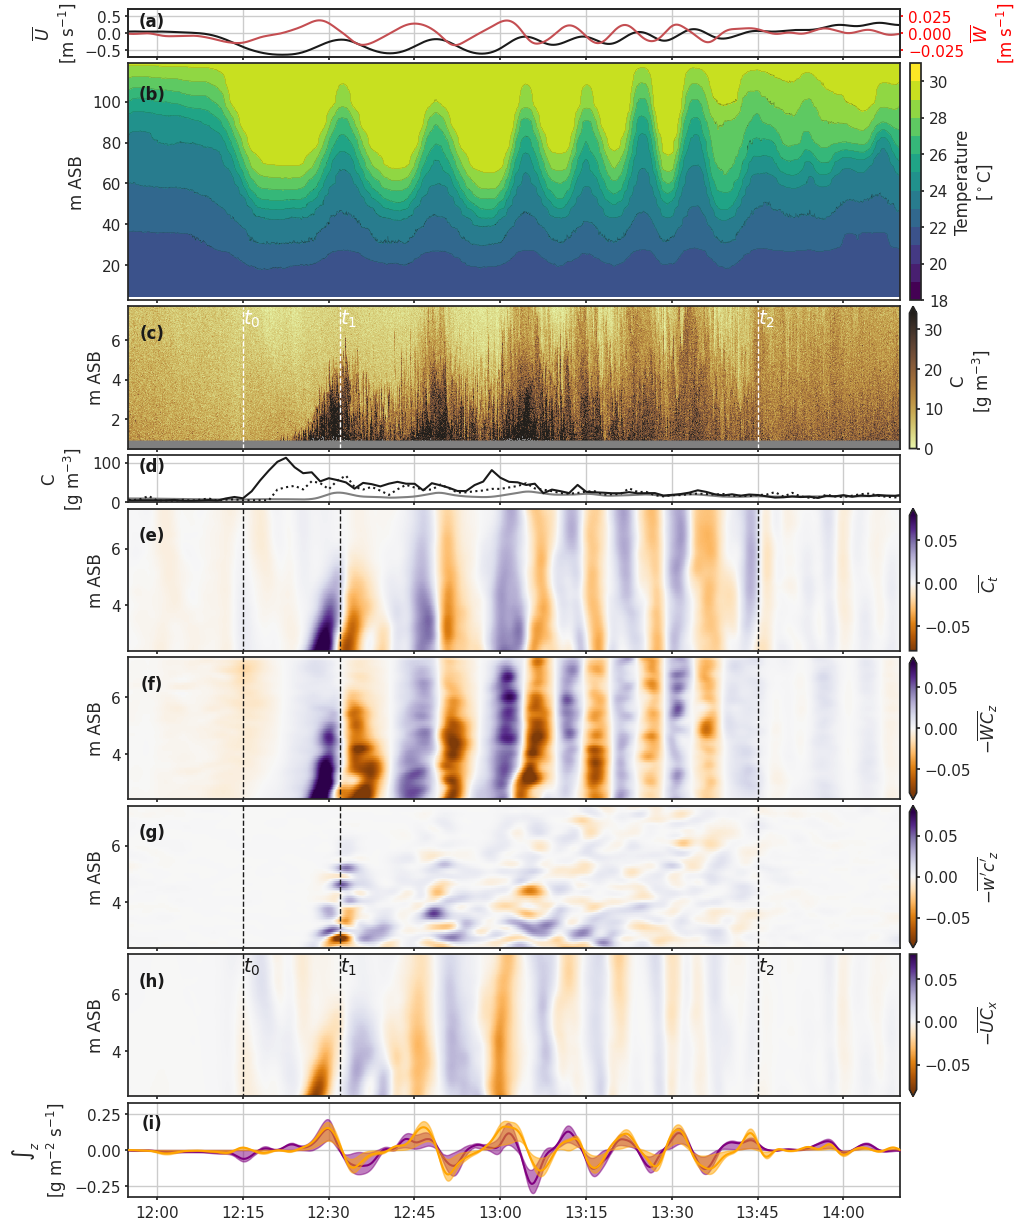

In [10]:
fig, ax = plotall_grl(ds, u_r_mean, c_turb, t_list, temp_ix, tx_sig, ulinemin, wtick,\
                        ssc_uppp, ssc_good, wav_fronts, ylim)


saveagu(f'{fig_dir}/{wave_type}_E{int(ii+1)}_event_f1v4', fig)

In [11]:
def plot_paperprofiles_v2(t_list, wf, cb_labels, xlim=29, ylim=(2.4,7.42), z_smooth=4, color='k'):

    qtile = 0.341

    # Plot the summary summs
    sn_ix = (t_list[0]['time'].values >= wf[0]) & (t_list[0]['time'].values <= wf[1])
    ed_ix = (t_list[0]['time'].values >= wf[1]) & (t_list[0]['time'].values <= wf[2])

    s_dist = t_list[0].height.sel(height=slice(ylim[0], ylim[1])).values
    xlim_adjust = 0 

    fig, ax = plt.subplots(2, 4, figsize=(12,6), gridspec_kw={'wspace':0.07, 'hspace':0.05})
    for x, z, f_term in zip(ax[0], ax[1], t_list):

        ti_gf = nan_gauss_xr(f_term.isel(time=sn_ix), z_smooth, axis=[0]).sel(height=slice(ylim[0], ylim[1]))
        ti_t = ti_gf.integrate('time', datetime_unit='s').median('sample')

        x.plot(ti_t, s_dist, c=color, zorder=10)
        ti_05 = ti_gf.integrate('time', datetime_unit='s').quantile(0.5-qtile, dim='sample', skipna=False)
        ti_95 = ti_gf.integrate('time', datetime_unit='s').quantile(0.5+qtile, dim='sample', skipna=False)
        x.fill_betweenx(s_dist, x1=ti_05, x2=ti_95, color=color, alpha=0.5, zorder=10)
        x.text(0.86, 0.85, str(int(ti_t.integrate('height'))), transform=x.transAxes,\
               c=color)

        ed_gf = nan_gauss_xr(f_term.isel(time=ed_ix), z_smooth, axis=[0]).sel(height=slice(ylim[0], ylim[1]))  
        ed_t = ed_gf.integrate('time', datetime_unit='s').median('sample')
        z.plot(ed_t, s_dist, c=color, zorder=10)
        tl_05 = ed_gf.integrate('time', datetime_unit='s').quantile(0.5-qtile, dim='sample', skipna=False)
        tl_95 = ed_gf.integrate('time', datetime_unit='s').quantile(0.5+qtile, dim='sample', skipna=False)
        z.fill_betweenx(s_dist, x1=tl_05, x2=tl_95, color=color, alpha=0.5, zorder=10)
        z.text(0.86, 0.85, str(int(ed_t.integrate('height'))), transform=z.transAxes,\
               c=color)

    for ix, (xx, cbl) in enumerate(zip(ax.flatten(), cb_labels)):
        if ix < 4:
            xx.set_title(cbl)

    for ix, xx in enumerate(ax.flatten()):
        # xlim_adjust = np.nanmax([xlim_adjust, np.nanmax(np.abs([ti_05, ti_95, tl_05, tl_95]))])
        xx.set_xlim(-xlim, xlim)
        # x.set_xticks([-200,0,200])
        xx.set_ylim(ylim[0], ylim[1])
        xx.grid()
        if (xx != ax[0][0]) & (xx != ax[1][0]):
            xx.set_yticklabels('')
        else:
            xx.set_ylabel('m ASB')
        if ix < 4:
            xx.set_xticklabels('')
        else:
            xx.set_title('')
            xx.set_xlabel('[g m$^{-3}$]')

    # for x in ax.flatten():
        # x.set_xlim(-xlim_adjust, xlim_adjust)
        # Set ticks to nearest 10 of xlim/2
        # xlim_round = np.round(xlim_adjust/2, -1)
        # x.set_xticks(np.arange(-xlim_round, xlim_round+1, xlim_round))

    return fig, ax

In [12]:
new_labels = ['$\int_t$' + cbc for cbc in cb_labels]

Loaded NLIW_E1_fluxattrs.nc
Loaded NLIW_E3_fluxattrs.nc
Loaded NLIW_E4_fluxattrs.nc
Loaded NLIW_E5_fluxattrs.nc
Loaded NLIW_E6_fluxattrs.nc
Loaded NLIW_E7_fluxattrs.nc
Loaded NLIW_E8_fluxattrs.nc
Loaded NLIW_E9_fluxattrs.nc
Loaded NLIW_E10_fluxattrs.nc
Loaded NLIW_E11_fluxattrs.nc


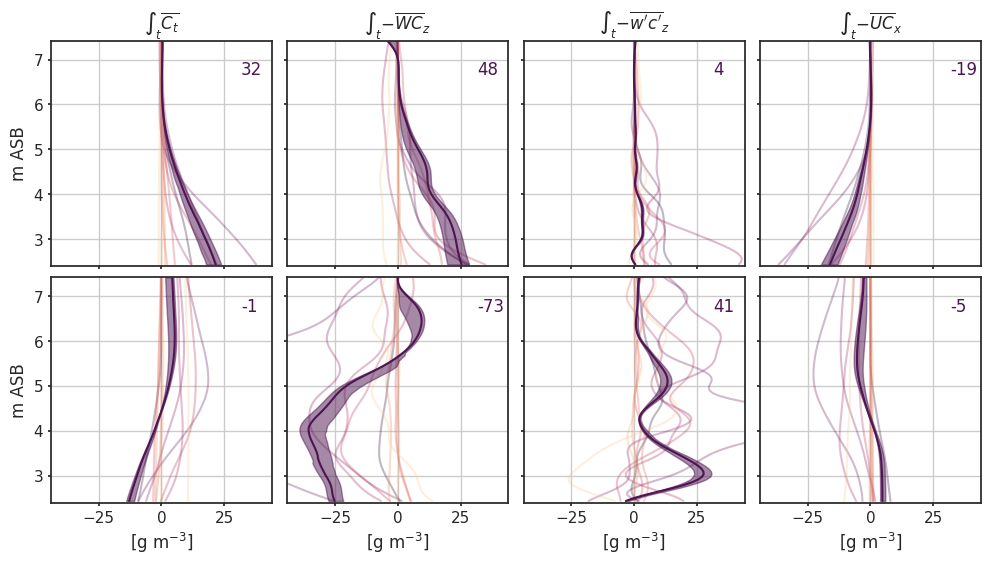

In [13]:
col = cm.matter_r(np.linspace(0, 0.9, len(wav_tx)))
fig3, ax3 = plot_paperprofiles_v2(t_list, wav_fronts[1], new_labels, xlim=44, ylim=ylim, color=col[1])
z_smooth=4
s_dist = t_list[0].height.sel(height=slice(ylim[0], ylim[1])).values

# Load wave data
for ii, (wt, wf) in enumerate(zip(wav_tx, wav_fronts)):
    if (ii != 1):
    
        # Load fluxes
        sig_fil = f'{wave_type}_E{int(ii+1)}_fluxattrs.nc'
        vel_file = os.path.join(load_dir, sig_fil)
        ds = xr.open_dataset(vel_file)
        xr.Dataset.close(ds)
        print(f'Loaded {sig_fil}')

        t_samp = calc_flux(ds, ds.attrs['est_celerity'])

        # Plot the summary summs
        sn_ix = (t_samp[0]['time'].values >= wf[0]) & (t_samp[0]['time'].values <= wf[1])
        ed_ix = (t_samp[0]['time'].values >= wf[1]) & (t_samp[0]['time'].values <= wf[2])

        for x, z, f_term in zip(ax3[0], ax3[1], t_samp):

            ti_gf = nan_gauss_xr(f_term.isel(time=sn_ix), z_smooth, axis=[0]).sel(height=slice(ylim[0], ylim[1]))
            ti_t = ti_gf.integrate('time', datetime_unit='s')
            x.plot(ti_t, s_dist, c=col[ii], zorder=1, alpha=0.3)

            ed_gf = nan_gauss_xr(f_term.isel(time=ed_ix), z_smooth, axis=[0]).sel(height=slice(ylim[0], ylim[1]))  
            ed_t = ed_gf.integrate('time', datetime_unit='s')
            z.plot(ed_t, s_dist, c=col[ii], zorder=1, alpha=0.3)

saveagu(os.path.join(fig_dir, f'{wave_type}_E{int(ii+1)}_profiles_f1v4'), fig3)